In [1]:
%matplotlib inline
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from sklearn.preprocessing import Imputer ==> classe excluida do sklearn, sendo substituida pela SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from functools import partial
from modAL.batch import uncertainty_batch_sampling


In [2]:
#carrega o dataset
dados = pd.read_csv('/home/erasmor/Área de Trabalho/CSE-CIC-IDS2018/1000amostras_DDoS.csv',sep=",",encoding = 'utf-8',  header=0,na_values='.')
#remove valores infinitos
dados = dados.replace(-np.Inf, np.nan)
#substitui valores NaN
dados.fillna(dados.mean())
dados.fillna(dados.mean(), inplace=True)


In [3]:
#mostra como está a base de dados
dados.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,649717,8,7,1441,4696,1112,0,180125.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,53,17,2528,1,1,36,144,36,36,36.000000,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,53621,6,44,2,0,0,0,0,0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,445,6,642262,6,5,455,338,140,0,75.833333,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,53,17,198,1,1,35,51,35,35,35.000000,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [4]:
# verifica quantas instâncias (linhas) e quantos atributos (colunas) a base de dados contém
print("numero de linhas e colunas: ",dados.shape)

numero de linhas e colunas:  (3000, 79)


In [5]:
#visualizar distribições por classes contidas no csv - informar nome da classe alvo
print(dados.groupby('Label').size())

Label
Benign                  1000
DDOS attack-HOIC        1000
DDOS attack-LOIC-UDP    1000
dtype: int64


In [6]:
#define as colunas de atributos e a coluna da classe (de 0 a 72 são atributos e após a 72 é a classe)
# "X_raw" é features/atributos e "y_raw" é target/classe ==> As duas formas abaixo dão certo.
#array = dataset.values
#X_raw = array[:,0:72]
#y_raw = array[:,72]
X_raw = dados.iloc[:, :-1].values # atributos
y_raw = dados.iloc[:, 78].values # classe de ataques
#teste
X_raw = np.nan_to_num(X_raw.astype(np.float32))

In [7]:
X_raw

array([[4.430000e+02, 6.000000e+00, 6.497170e+05, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [5.300000e+01, 1.700000e+01, 2.528000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [5.362100e+04, 6.000000e+00, 4.400000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [8.000000e+01, 1.700000e+01, 9.286563e+07, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.000000e+01, 1.700000e+01, 7.739941e+07, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.000000e+01, 1.700000e+01, 7.593000e+07, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]], dtype=float32)

In [8]:
y_raw

array(['Benign', 'Benign', 'Benign', ..., 'DDOS attack-LOIC-UDP',
       'DDOS attack-LOIC-UDP', 'DDOS attack-LOIC-UDP'], dtype=object)

In [9]:
#transformar a variável Y com valores categóricos das classses de ataques em valores:
labelencoder_y = LabelEncoder()
y_raw = labelencoder_y.fit_transform(y_raw)

In [10]:
y_raw

array([0, 0, 0, ..., 2, 2, 2])

In [11]:
#X_raw_normalize = MinMaxScaler(X_raw_normalize.reshape(0, 1)).reshape(len(X_raw_normalize))
#X_raw_normalizetd2 = (X_raw_normalize - X_raw_normalize.min(axis=0)) / (X_raw_normalize.max(axis=0) - X_raw_normalize.min(axis=0))
# Obtendo os nomes das colunas do DataFrame como uma lista.
cols = list(dados.columns)
# colunas que nao serao normalizadas
cols.remove('Label')
# Copiando os dados e aplicando a normalizacao por reescala nas colunas do DataFrame que contem
# valores continuos. Por padrao, o metodo minmax_scale reescala com min=0 e max=1.
dados = dados[~dados.isin([np.nan, np.inf, -np.inf]).any(1)]
dados[cols] = dados[cols].apply(minmax_scale)
#dados_amp = dados.copy()
#dados_amp[cols] = dados[cols].apply(minmax_scale)
#print (dados_dist.dtypes)
#dados_amp[cols]
#dados[cols]
#dados[cols].info()
#teste
#X_raw = dados[cols].iloc[:, :].values # atributos
#X_raw = np.nan_to_num(X_raw.astype(np.float32))
#X_raw

In [12]:
# Instanciando um PCA. O parametro n_components indica a quantidade de dimensoes que a base
# original sera reduzida.
pca = PCA(n_components=2, whiten=True)

In [13]:
# Aplicando o pca na base de dados. O atributo 'values' retorna um numpy.array
# de duas dimensões (matriz) contendo apenas os valores numericos do DataFrame.
dados_pca = pca.fit_transform(dados[cols].values)

In [14]:
dados_pca

array([[-0.61382297, -1.77290089],
       [-0.04795057, -0.80680042],
       [-0.85309235,  0.01523398],
       ...,
       [ 1.20789196, -0.02266115],
       [ 0.84691046, -0.1622209 ],
       [ 0.84729299, -0.16963499]])

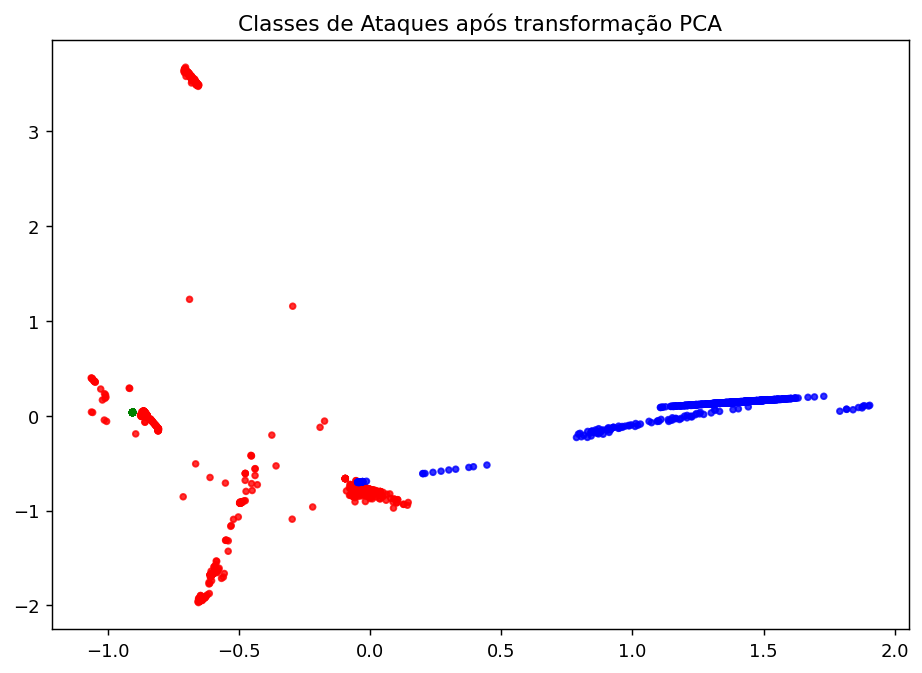

In [15]:
# Isolate the data we'll need for plotting.
x_component, y_component = dados_pca[:, 0], dados_pca[:, 1]
colormap = {'Benign': 'red', 'DDOS attack-HOIC': 'green', 'DDOS attack-LOIC-UDP': 'blue'}
colors = [colormap[x] for x in dados['Label']]
# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c = colors, cmap='viridis', s=10, alpha=8/10)
plt.title('Classes de Ataques após transformação PCA')
plt.show()

In [16]:
#Particionamento do conjunto de dados em um conjunto de treinamento L e U. Primeiro especificamos
#conjunto de treinamento L consistindo em 3 exemplos aleatórios. Os exemplos restantes vão para
#o pool "sem rótulo" U.

#Isole o exemplos para o conjunto de dados rotulado:

n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

#Isola os exemplos sem treinamento para consultar.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from sklearn.impute import SimpleImputer


# Especifique o estimador principal (K-NN) junto com o modelo de aprendizado ativo.
knn = KNeighborsClassifier(n_neighbors=3)
# Predefina a amostragem de lote para recuperar 3 amostras por vez.
BATCH_SIZE = 3
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

# Especifique o modelo de aprendizagem ativa.
learner = ActiveLearner(estimator=knn,X_training=X_train,y_training=y_train,query_strategy=preset_batch)


In [18]:
# Isole os dados para plotar.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Registre a pontuação do learner nos dados brutos.
unqueried_score = learner.score(X_raw, y_raw)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2999 but corresponding boolean dimension is 3000

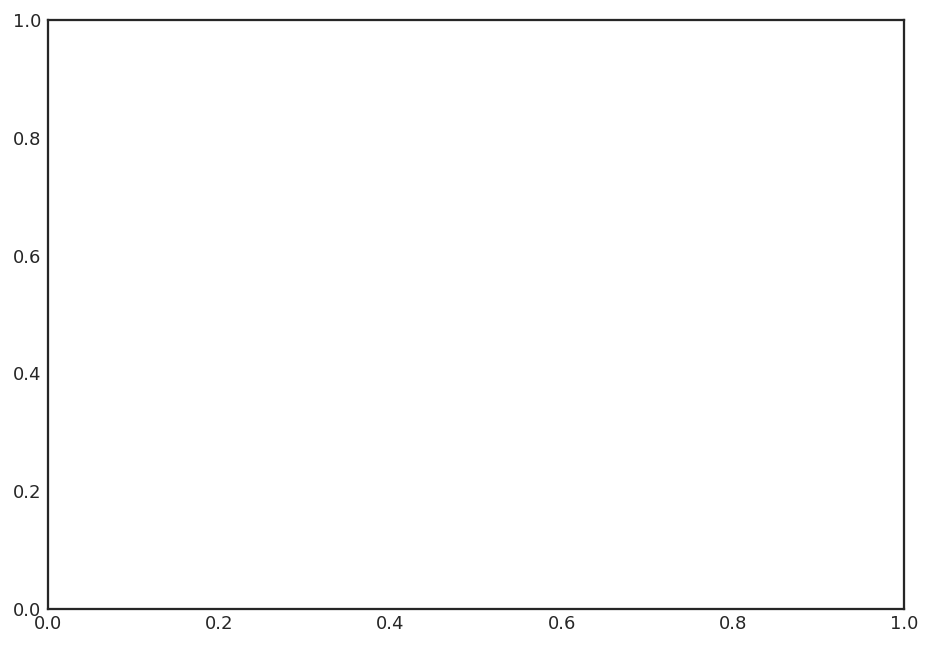

In [20]:
# Trace os resultados de classificação.
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
    ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
    ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')
    ax.legend(loc='lower right')
    ax.set_title("ActiveLearner predições de classe (Accuracy: {score:.3f})".format(score=unqueried_score))
    plt.show()

In [29]:
# Atualize o modelo por meio de amostragem baseada em pool do conjunto de dados "sem etiqueta" U
# Pool-based sampling
N_RAW_SAMPLES = 20
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE
performance_history = [unqueried_score]

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)

    

Accuracy after query 1: 0.9987
Accuracy after query 2: 0.9983
Accuracy after query 3: 0.9983
Accuracy after query 4: 0.9983
Accuracy after query 5: 0.9983
Accuracy after query 6: 0.9983


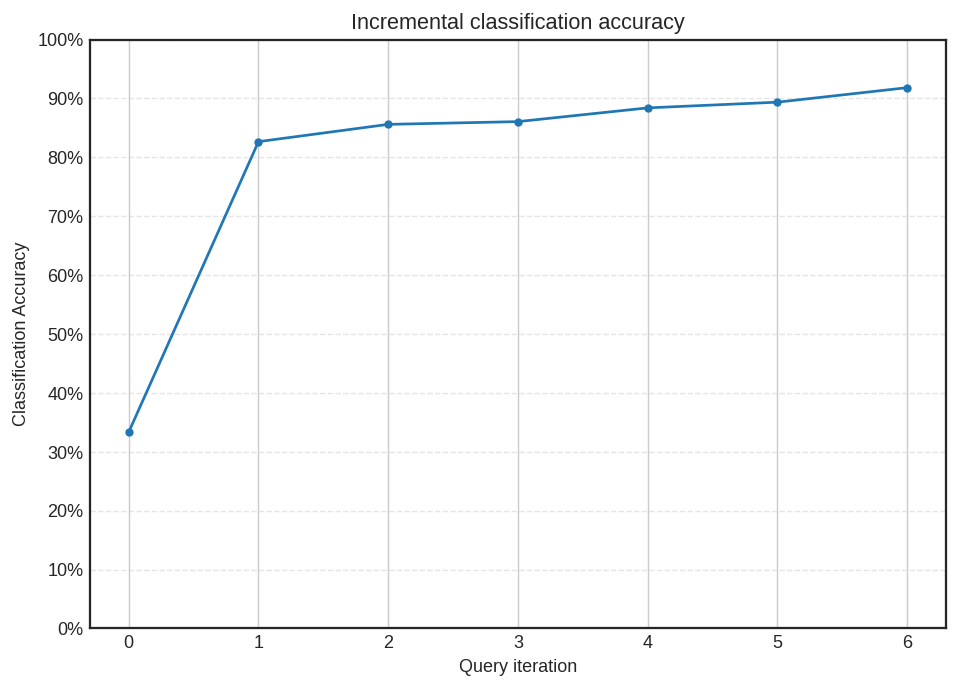

In [24]:
# Plot our performance over time.
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.plot(performance_history)
    ax.scatter(range(len(performance_history)), performance_history, s=13)

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
    ax.xaxis.grid(True)

    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax.set_ylim(bottom=0, top=1)
    ax.yaxis.grid(True, linestyle='--', alpha=1/2)

    ax.set_title('Incremental classification accuracy')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Classification Accuracy')

    plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
    ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')

    ax.set_title('Classification accuracy after {n} queries (* {batch_size} samples/query = {total} samples): {final_acc:.3f}'.format(
        n=N_QUERIES,
        batch_size=BATCH_SIZE,
        total=N_QUERIES * BATCH_SIZE,
        final_acc=performance_history[-1]
    ))
    ax.legend(loc='lower right')

    plt.show()